In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms, utils
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

from google.colab.patches import cv2_imshow 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

In [0]:
# 이미지 픽셀을 Tensor 형으로 바꿔주는 transform 정의
transform = transforms.Compose([transforms.ToTensor()])

# Fashion MNIST Dataset 가져오기
trainset = datasets.FashionMNIST(root = './.data/', train = True, download  = True, transform = transform)
testset = datasets.FashionMNIST(root = './.data/', train = False, download  = True, transform = transform)

print(trainset, '\n\n', testset)
batch_size = 16

# Dataset의 Data를 다루기 용이한 DataLoadet 정의
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size  = batch_size)
test_loader = torch.utils.data.DataLoader(dataset = testset, batch_size = batch_size)

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw


Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw


Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw


Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw
Processing...
Done!
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./.data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 

 Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./.data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


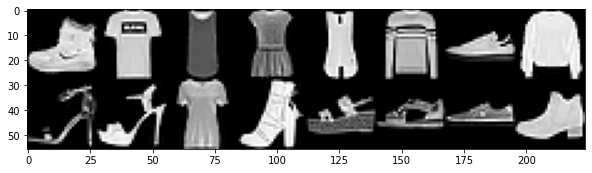

Ankle boot
T-shirt/top
T-shirt/top
Dress
T-shirt/top
Pullover
Sneaker
Pullover
Sandal
Sandal
T-shirt/top
Ankle boot
Sandal
Sandal
Sneaker
Ankle boot


In [0]:
# DataLoader 이용, Data를 Batch 단위로 뽑아오기 위한 iterator 설정
dataiter = iter(train_loader)
# next : Iterator가 메모리 순서 상 다음 Data를 가져온다
images, labels = next(dataiter)

# 이미지 출력을 위한 전처리
img = utils.make_grid(images, padding=0)
npimg = img.numpy()

# Matplotlib를 이용한 이미지 출력
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

# Label과 명칭을 짝지어주는 Dictionary
classes = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# 출력된 이미지와 맞는 명칭 출력
for label in labels:
    index = label.item()
    print(classes[index])

In [0]:
# MLP Model 정의
class MLP(torch.nn.Module):
  def __init__(self, input_size):
    super(MLP, self).__init__()
    # MLP 모델 구성을 위한 층 정의
    self.linear_1 = torch.nn.Linear(input_size, 256)
    self.linear_2 = torch.nn.Linear(256, 64)
    self.linear_3 = torch.nn.Linear(64, 10)
        
  # Feed-forwarding 을 위한 함수 정의
  def forward(self, input_tensor):
    x = F.relu(self.linear_1(input_tensor.view(-1,784)))
    x = self.linear_2(x)
    x = self.linear_3(x)
    y_pred = F.softmax(x)
    return y_pred

# CNN Model 정의
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # CNN 모델 구성을 위한 층 정의
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
    self.linear_1 = nn.Linear(32*7*7, 128)
    self.linear_2 = nn.Linear(128, 10)
    
  # Feed-forwarding 을 위한 함수 정의
  def forward(self, x):
    x = F.relu(self.conv1(x.view(batch_size, 1, 28, 28)))
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.pool(x)
    x = F.relu(self.linear_1(x.view(-1, 32*7*7)))
    y_pred = F.softmax(self.linear_2(x))
    return y_pred

In [0]:
model_mlp = MLP(784).to(device)
optimizer = optim.Adam(model_mlp.parameters())
summary(model_mlp, (int(batch_size/2), 1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                   [-1, 64]          16,448
            Linear-3                   [-1, 10]             650
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.00
Params size (MB): 0.83
Estimated Total Size (MB): 0.86
----------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [0]:
model_cnn = CNN().to(device)
optimizer = optim.Adam(model_cnn.parameters())
summary(model_cnn, (int(batch_size/2), 1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 16, 28, 28]           2,320
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
            Conv2d-5           [-1, 32, 14, 14]           9,248
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                  [-1, 128]         200,832
            Linear-8                   [-1, 10]           1,290
Total params: 218,490
Trainable params: 218,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.32
Params size (MB): 0.83
Estimated Total Size (MB): 1.18
----------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
#model = model_mlp
model = model_cnn

In [0]:
# 학습 함수 정의
def train(model, train_loader, optimizer, epoch):
  # train() / eval() : train 모드일 경우 Gradient 자동계산, eval 모드일 경우 계산 X
  model.train()

  # Batch 당 학습을 위한 반복문
  for batch_idx, (data, label) in enumerate(train_loader):
    
    data, label = data.to(device), label.to(device) # Data를 GPU로 보낸다

    optimizer.zero_grad() # Gradient 계산 초기화
    output = model(data) # Feed-forward
    loss = F.cross_entropy(output, label) # Loss 계산

    loss.backward()
    optimizer.step() # Back propagation 및 가중치 Update

    if batch_idx % 1000 == 0: # 학습 시 출력문
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
            .format(epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()
                    )
            )

In [0]:
# 학습 후 모델 사용시
def evaluate(model, test_loader):

  model.eval() # eval mode : Dropout 자동 제거
  test_loss = 0 # Total Loss 계산을 위한 누적값 초기화
  correct = 0 # Accuracy 계산을 위한 누적값 초기화

  with torch.no_grad(): # Gradient 계산이 없음을 의미
    for data, label in test_loader:
      data, label = data.to(device), label.to(device)
      output = model(data)

      # 배치 오차를 합산
      test_loss += F.cross_entropy(output, label,
                                    reduction='sum').item()

      # 가장 높은 값을 가진 인덱스가 바로 예측값
      # Tensor.max(1, keepdim=True)[1] / 1 : 최댓값을 찾을 차원 정의 / keepdim=True : Input 차원 유지
      pred = output.max(1, keepdim=True)[1]

      # label.view_as(pred) : pred와 label의 차원 맞추기
      # pred.eq(label.view_as(pred)) : pred와 label이 동일할 경우 True, 아니면 False 값을 갖는 리스트 반환
      # pred.eq(label.view_as(pred)).sum() : 반환된 리스트의 값을 전부 더한다
      # pred.eq(label.view_as(pred)).sum().item() : Tensor형 값에서 int형의 값만 따온다
      correct += pred.eq(label.view_as(pred)).sum().item()

  # Loss, Accuracy 계산 후 반환
  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [0]:
a = torch.Tensor([[[1,2,3,4],[5,6,7,8]]])
b = torch.Tensor([[1,2,3,4],[5,6,7,8]])
print(a.shape)
print(b.shape, '\n')

print(a.max(2), '\n')
print(a.max(1), '\n')

print(a.max(1, keepdim=True), '\n')

print(b.view_as(a))
print(a.eq(b.view_as(a)))
print(a.eq(b.view_as(a)).sum())
print(a.eq(b.view_as(a)).sum().item())

torch.Size([1, 2, 4])
torch.Size([2, 4]) 

torch.return_types.max(
values=tensor([[4., 8.]]),
indices=tensor([[3, 3]])) 

torch.return_types.max(
values=tensor([[5., 6., 7., 8.]]),
indices=tensor([[1, 1, 1, 1]])) 

torch.return_types.max(
values=tensor([[[5., 6., 7., 8.]]]),
indices=tensor([[[1, 1, 1, 1]]])) 

tensor([[[1., 2., 3., 4.],
         [5., 6., 7., 8.]]])
tensor([[[True, True, True, True],
         [True, True, True, True]]])
tensor(8)
8


In [0]:
epochs = 10
# Epoch을 위한 반복문
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch) # 학습
    test_loss, test_accuracy = evaluate(model, test_loader) # 평가 (Test == Val)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305444
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.880257
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.712718
Train Epoch: 1 [48000/60000 (80%)]	Loss: 1.587356
[1] Test Loss: 1.6534, Accuracy: 80.73%
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.632532
Train Epoch: 2 [16000/60000 (27%)]	Loss: 1.648485
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.711176
Train Epoch: 2 [48000/60000 (80%)]	Loss: 1.584965
[2] Test Loss: 1.6608, Accuracy: 80.01%
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.649202
Train Epoch: 3 [16000/60000 (27%)]	Loss: 1.586201
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.648803
Train Epoch: 3 [48000/60000 (80%)]	Loss: 1.538500
[3] Test Loss: 1.6472, Accuracy: 81.28%
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.648610
Train Epoch: 4 [16000/60000 (27%)]	Loss: 1.648684
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.763712
Train Epoch: 4 [48000/60000 (80%)]	Loss: 1.586132
[4] Test Loss: 1.6188, Accuracy: 84.17%
Train Epoch: 5 [0/60000 (0%)]	Loss: 1.711150
Train Epoch: 5 

In [0]:
# 위의 train의 경우와 동일
dataiter = iter(test_loader)
images, labels = next(dataiter)

# images(CPU, Tensor) -> images(GPU, Tensor) -> output(GPU, Tensor) -> output(CPU, Tensor) -> Gradient 계산 제거 -> output(CPU, ndarray)
output = model(images.to(device)).to('cpu').detach().numpy()

for i in range(batch_size):
  # images[i](GPU, Tensor) -> images[i](CPU, Tensor) -> Gradient 계산 제거 -> 1인 차원 제거 -> images[i](CPU, ndarray)
  cv2_imshow(255*images[i].to('cpu').detach().squeeze().numpy())

  # output[i](list (shape:(10,)) -> 값이 최대인 index (int) -> index에 해당하는 옷 종류 (string)
  print(classes[np.argmax(output[i])])

  if np.argmax(output[i]) != labels[i]:
    print("WRONG PREDICTION")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Ankle boot


Pullover


Trouser


Trouser


Shirt


Trouser


Pullover
WRONG PREDICTION


Shirt


Sandal


Sneaker


Coat


Sandal


Sandal
WRONG PREDICTION


Dress


Coat


Trouser


In [0]:
# 본인의 구글 드라이브 → 지금 실행중인 코드

# google.colab.drive : 구글 드라이브에서 파일을 가져오기 위한 코드를 담고 있다.
from google.colab import drive

# 본인의 구글 드라이브를 '/gdrive' 라는 경로로 하여 쓸 수 있다.
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# 모델은 pt 파일 형태로 저장됩니다
torch.save(model.state_dict(), '/gdrive/My Drive/FashionMNIST_MLP.pt')

# 모델을 불러오기 위해 지워줍니다
del model

model = MLP(784).to(device)
model.load_state_dict(torch.load('/gdrive/My Drive/FashionMNIST_MLP.pt'))
model.to(device)

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (linear_2): Linear(in_features=256, out_features=64, bias=True)
  (linear_3): Linear(in_features=64, out_features=10, bias=True)
)